In [1]:
# demo storm coordinates
import pandas as pd
import numpy as np
import geojson
import matplotlib.pyplot as plt
%run -i storm_coords.py

In [2]:
### test 
lat1 = 47.
lon1 = -62.1
lat2 = 46.
lon2 = -62.1

d, az = dist_bearing( lon1, lat1, lon2, lat2)
print(d, az)

111.19492664455889 180.0


#### Explore the geojson file a bit

In [3]:
with open('/vortexfs1/home/csherwood/proj/NOPP_Idalia/idalia_track.json') as f:
    gj = geojson.load(f)
features = gj['features']
print(features[0])
print(features[0]['geometry'])
print(features[0]['geometry']['coordinates'][0])
print(features[0]['properties'])
print(features[0]['properties']['time_utc'])

print(len(features))

{"geometry": {"coordinates": [-84.0, 16.0], "type": "Point"}, "properties": {"max_wind_speed_mph": 17.26, "minimum_sea_level_pressure_mb": 0.0, "radius_to_max_wind_nmi": 0.0, "storm_class": "DB", "time_utc": "2023-08-24T18:00:00"}, "type": "Feature"}
{"coordinates": [-84.0, 16.0], "type": "Point"}
-84.0
{'time_utc': '2023-08-24T18:00:00', 'max_wind_speed_mph': 17.26, 'minimum_sea_level_pressure_mb': 0.0, 'radius_to_max_wind_nmi': 0.0, 'storm_class': 'DB'}
2023-08-24T18:00:00
65


In [4]:
mph2ms = 0.44704
nmi2km = 1.852
time_utc = []
lat = []
lon = []
max_wind_speed_ms = []
radius_to_max_wind_km = []
for feature in features:
    lon.append( feature['geometry']['coordinates'][0])
    lat.append( feature['geometry']['coordinates'][1])
    time_utc.append( feature['properties']['time_utc'])
    max_wind_speed_ms.append( feature['properties']['max_wind_speed_mph']*mph2ms )
    radius_to_max_wind_km.append( feature['properties']['radius_to_max_wind_nmi']*nmi2km )

# convert time stamps to datetime64
dt = pd.to_datetime(time_utc)

In [5]:
# Put in a dataframe and drop duplicates.
# dfo = pd.DataFrame( {'time_utc': time_utc}, index = dt)
dfo = pd.DataFrame({'time_utc': time_utc,'lat': lat, 'lon': lon,
                    'max_wind_speed_ms': max_wind_speed_ms, 
                    'radius_to_max_wind_km': radius_to_max_wind_km}, 
                   index = dt).drop_duplicates()

In [20]:
# compute distance and bearing between unique points
%run -i 'storm_coords.py'
lon = np.array( dfo['lon'].values)
lat = np.array( dfo['lat'].values)

dist = np.ones_like( lon )
brg = np.ones_like( dist )
for i in range(len( lon )-1):
    dist[i],brg[i] = dist_bearing(lon[i], lat[i], lon[i+1], lat[i+1])

# make all the lists the same length
dist[i+1]=dist[i]
brg[i+1]=brg[i]

# add to the dataframe
dfo['distance_to_next_km']=dist
dfo['bearing_to_next_geo']=brg
dfo.to_csv('idalia_track_dist_brg.csv')

In [19]:
# example interpolation
import calendar
def toTimestamp(d):
    return calendar.timegm(d.timetuple())

t = np.array( [toTimestamp( d ) for d in dfo.index ] )
print(t)
print(len(t))
dti = calendar.timegm( pd.to_datetime( '2023-08-29 1700').timetuple() )
print(dti)
tindex=np.argwhere(t<=dti)[-1]
print(tindex, t[tindex])
tarray = np.squeeze( np.array( (t[tindex],t[tindex+1])) )
one = np.squeeze( np.array( (0., 1.) ) )
print(tarray)
print(one)
result = np.interp(dti, tarray, one)
print(result)

[1692900000 1692921600 1692943200 1692964800 1692986400 1693008000
 1693029600 1693051200 1693072800 1693094400 1693116000 1693137600
 1693159200 1693180800 1693202400 1693224000 1693245600 1693267200
 1693288800 1693310400 1693332000 1693353600 1693375200 1693396800
 1693418400 1693440000 1693461600 1693483200 1693504800 1693526400
 1693548000 1693569600 1693591200 1693612800 1693634400 1693656000
 1693677600]
37
1693328400
[19] [1693310400]
[1693310400 1693332000]
[0. 1.]
0.8333333333333333


* load track geojson
* convert to lists of points with time, lat, lon, radius, and max winds
* calculate distance and bearing between points
* load list of buoy locations with time, lat, long
* determine storm location, bearing, and translation speed for buoy time
* determine storm coordinates (with and without radial scaling) for buoy location

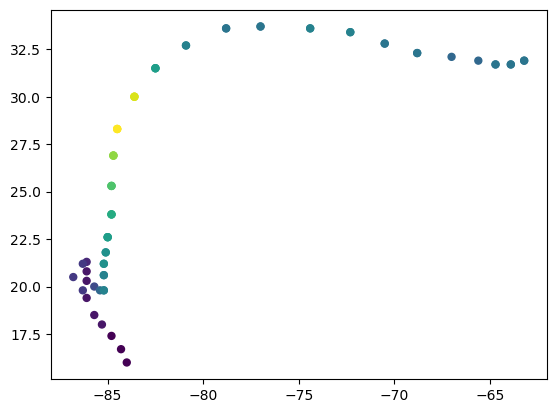

In [11]:
plt.scatter(lon,lat,25,max_wind_speed_ms)

In [12]:
df = pd.read_csv('/vortexfs1/home/csherwood/proj/NOPP_Idalia/idalia_track.csv')
df

,LONGITUDE,LATITUDE,STORMNAME,DTG,YEAR,MONTH,DAY,HHMM,MSLP,BASIN,STORMNUM,STORMTYPE,INTENSITY,SS,LAT,LON
0,-86.1,21.3,TEN,2.023083e+09,2023.0,8,26.0,1800,1006.0,al,10.0,TD,25.0,0.0,21.3,-86.1
1,-86.3,21.2,TEN,2.023083e+09,2023.0,8,27.0,0,1005.0,al,10.0,TD,30.0,0.0,21.2,-86.3
2,-86.8,20.5,TEN,2.023083e+09,2023.0,8,27.0,600,1001.0,al,10.0,TD,30.0,0.0,20.5,-86.8
3,-86.3,19.8,TEN,2.023083e+09,2023.0,8,27.0,1200,1001.0,al,10.0,TD,30.0,0.0,19.8,-86.3
4,-85.7,20.0,IDALIA,2.023083e+09,2023.0,8,27.0,1800,996.0,al,10.0,TS,35.0,0.0,20.0,-85.7
5,-85.4,19.8,IDALIA,2.023083e+09,2023.0,8,28.0,0,992.0,al,10.0,TS,45.0,0.0,19.8,-85.4
6,-85.2,19.8,IDALIA,2.023083e+09,2023.0,8,28.0,600,988.0,al,10.0,TS,55.0,0.0,19.8,-85.2
7,-85.2,20.6,IDALIA,2.023083e+09,2023.0,8,28.0,1200,989.0,al,10.0,TS,55.0,0.0,20.6,-85.2
8,-85.2,21.2,IDALIA,2.023083e+09,2023.0,8,28.0,1800,987.0,al,10.0,TS,60.0,0.0,21.2,-85.2
9,-85.1,21.8,IDALIA,2.023083e+09,2023.0,8,29.0,0,983.0,al,10.0,TS,60.0,0.0,21.8,-85.1
